In [668]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

## Defining paramters for the SGA

In [669]:
pop_size = 100
chromosome_length = 10
generation_number = 1
crossover_rate = 0.2
mutation_rate = 0.4
num_parents = int(np.floor(pop_size/2))
g_max = 10

## Defining the Individual

In [670]:
class Individual:
    def __init__(self, genotype, age) -> None:
        self.genotype = genotype
        self.phenotype = int(genotype, 2)
        self.sin_fitness = self.calculate_sin_fitness()
        self.children = []
        self.age = age

    def scaled_phenotype(self):
        genotype_length = len(self.genotype)
        scaling_factor = (2**7) / (2**genotype_length)
        scaled_value = self.phenotype * scaling_factor
        return scaled_value
    
    def calculate_sin_fitness(self):
        # Scaling by 1 to avoid negative values
        return np.sin(self.scaled_phenotype()) + 1
    
    def add_children(self, children):
        self.children += children

    def grow_older(self):
        self.age += 1
    
    def __repr__(self):
        return f"Individual(genotype={self.genotype}, phenotype={self.phenotype}, sin_fitness={self.sin_fitness})"

## Sin Synthetic Problem

*a) Implement a function to generate an initial population for your genetic
algorithm.*

We are choosing to initialize the population, according to the size parameters. The actual genotypes (0's and 1's) will be generated randomly.

In [671]:
def init_population():
    population = []
    
    for _ in range(pop_size):
        new_genotype = ""
        for _ in range(chromosome_length):
            new_genotype += str(random.randint(0,1))

        new_individual = Individual(new_genotype, age=0)
        population.append(new_individual)
    return population

*b) Implement a parent selection function for your genetic algorithm. This function
should find the fittest individuals in the population, and select parents based
on this fitness.*

Here we are using the fitness function given by the sine function, as explained in the task. Moreover we are implementing a roulette-wheel approach as parent selection.

In [672]:
def roulette_wheel_parent_selection(population):
    total_fitness = sum(individual.sin_fitness for individual in population)
    
    # Probability of choosing each individual based on the roulette wheel approach
    probabilities = [individual.sin_fitness/total_fitness for individual in population]

    # Choosing num_parents parents with the above probabilities for each individual
    parents = np.random.choice(population, size=num_parents, p=probabilities)
    
    return list(parents)

*c) Implement a function that creates two offspring from two parents through
crossover. The offspring should also have a chance of getting a random
mutation.*

In [673]:
def crossover(parent1, parent2):
    gene_cutoff = random.randint(1, chromosome_length - 1)

    genotype_1 = parent1.genotype[: gene_cutoff] + parent2.genotype[gene_cutoff:]
    genotype_2 = parent2.genotype[: gene_cutoff] + parent1.genotype[gene_cutoff:]

    child_1 = Individual(mutate(genotype_1), age=0)
    child_2 = Individual(mutate(genotype_2), age=0)

    parent1.add_children([child_1, child_2])
    parent2.add_children([child_1, child_2])

    return child_1, child_2
        
def mutate(genotype):
    if np.random.random() < mutation_rate:
        char_list = list(genotype)

        random_index = np.random.randint(len(char_list))

        char_list[random_index] = '0' if char_list[random_index] == '1' else '1'

        return ''.join(char_list)
    else:
        return genotype

*d) Implement survivor selection.*

- For a 1-person team: Implement one survivor selection function that
selects the survivors of a population based on their fitness.
- For a 2-person team: Implement two such survivor selection functions.

Survivor selection function 1 chooses based on age. It sorts the population based on age, from youngest to oldest. Then outputs the youngest individuals.

In [674]:
def age_selection(population):
    age_sorted_population = sorted(population, key=lambda x: x.age)
    return age_sorted_population[:pop_size]

Survivor selection function 2 uses tounrament selection. A set of individuals is randomly chosen, and the one with the highest fitness within this group is selected to survive. This process is repeated until the desired number of survivors is reached.

In [675]:
def tournament_selection(population):
    contestants = population.copy()
    winners = []

    while len(winners) != pop_size:
        if len(contestants) > 1:
            size = random.randint(2, len(contestants))
            trial = np.random.choice(contestants, size, replace=False)
            winner = max(trial, key=lambda x: x.sin_fitness)
            contestants.remove(winner)
            
            winners.append(winner)
        else:
            winner = contestants[0]
            winners.append(winner)
    
    return list(winners)

*e) Connect all the implemented functions to complete the genetic algorithm, and
run the algorithm with the sine fitness function. Throughout the generations
plot the individuals, values and fitness values with the sine wave.*

In [676]:
population = []

In [677]:
def sga(survivor_selection, population):
    g = 0
    population = init_population()

    while g < g_max:
        g += 1
        avg_fitness = plot_generation(population, generation=g)
        print("Average fitness of generation", g, "is", avg_fitness)
        print("Population size", len(population))
        new_population = []

        for individual in population:
            individual.grow_older()
            print("age =", individual.age)

        # Creating parents (mating pool)
        parents = roulette_wheel_parent_selection(population)
        
        # Shuffling mating pool
        random.shuffle(parents)
        parent1, parent2 = random.sample(parents, 2)

        while len(new_population) < len(population):
            parent1, parent2 = random.sample(parents, 2)
            
            if np.random.random() < crossover_rate:
                child1, child2 = crossover(parent1, parent2)
                new_population.extend([copy.deepcopy(child1), copy.deepcopy(child2), copy.deepcopy(parent1), copy.deepcopy(parent2)])

        # Survivor selection
        if survivor_selection == 'age':
            population = age_selection(new_population)
        elif survivor_selection == 'tournament':
            population = tournament_selection(new_population)

    return population


def plot_generation(population, generation):
    x = np.linspace(0, 128, 500)
    y = np.sin(x)
    plt.plot(x, y)

    fitness_pool = []

    # Plot each individual in the population
    for individual in population:
        phenotype = individual.scaled_phenotype()
        fitness = individual.sin_fitness - 1
        fitness_pool.append(fitness)
        plt.scatter(phenotype, fitness, alpha=1, color = 'orange')  

    plt.title('Population plot, generation ' + str(generation))
    plt.xlabel('Phenotype')
    plt.ylabel('Fitness')
    plt.grid(True)
    plt.show()

    return np.average(fitness_pool)



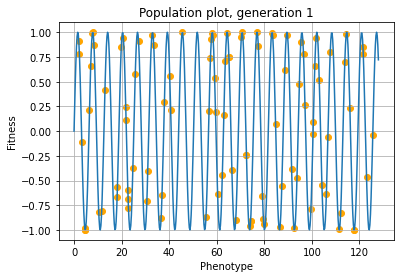

Average fitness of generation 1 is 0.08048745278637803
Population size 100
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1


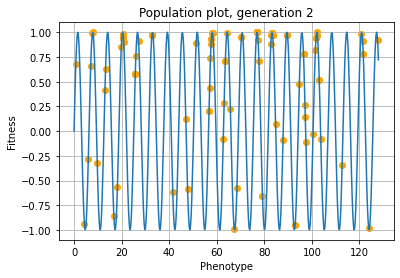

Average fitness of generation 2 is 0.5301618555608164
Population size 100
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2


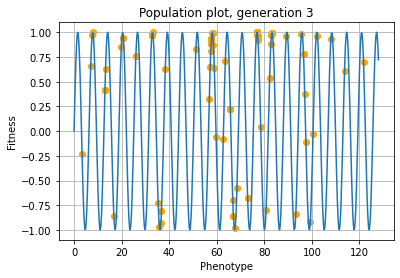

Average fitness of generation 3 is 0.5032101068091309
Population size 100
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3


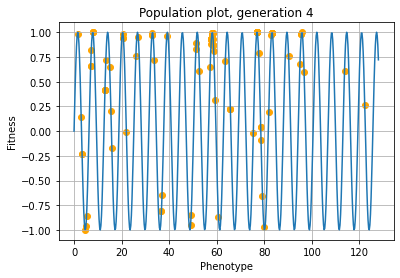

Average fitness of generation 4 is 0.5572567196965077
Population size 100
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 3
age = 3
age = 3
age = 3
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4


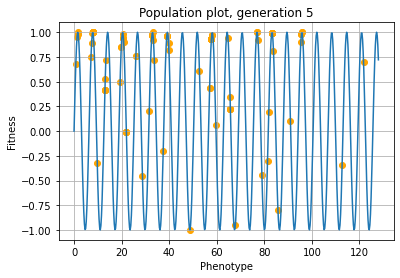

Average fitness of generation 5 is 0.6548847439967139
Population size 100
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5


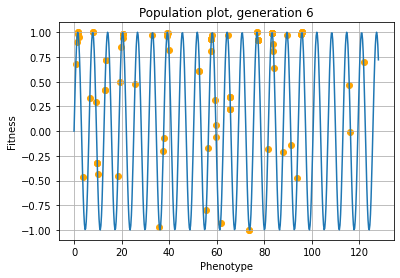

Average fitness of generation 6 is 0.5684899088805523
Population size 100
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 6
age = 6
age = 6
age = 6
age = 6
age = 6
age = 6
age = 6
age = 6
age = 6
age = 6


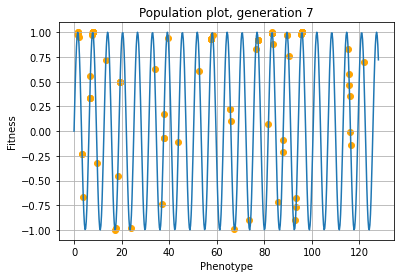

Average fitness of generation 7 is 0.53201058175508
Population size 100
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 4
age = 4
age = 4
age = 4
age = 4
age = 5
age = 5
age = 7
age = 7
age = 7
age = 7
age = 7
age = 7
age = 7
age = 7
age = 7
age = 7
age = 7
age = 7


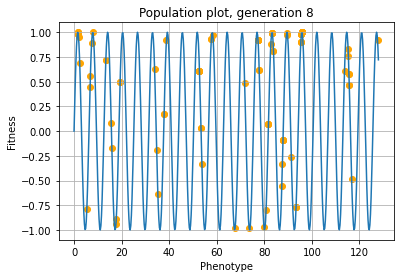

Average fitness of generation 8 is 0.461809640647513
Population size 100
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 5
age = 5
age = 5
age = 5
age = 6
age = 6
age = 8
age = 8
age = 8
age = 8
age = 8


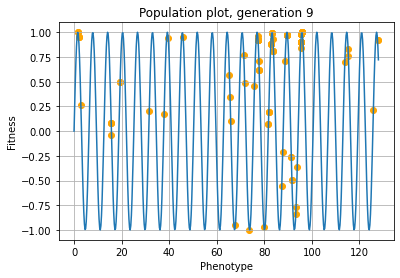

Average fitness of generation 9 is 0.5932842325107569
Population size 100
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 3
age = 3
age = 3
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 4
age = 5
age = 5
age = 9
age = 9
age = 9


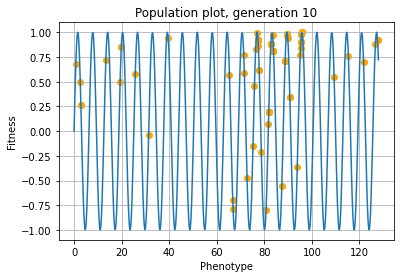

Average fitness of generation 10 is 0.6774615109730991
Population size 100
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 1
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 2
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 3
age = 4
age = 4
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5
age = 5


[Individual(genotype=1011111010, phenotype=762, sin_fitness=1.8426685926202349),
 Individual(genotype=1011110111, phenotype=759, sin_fitness=1.586896485426319),
 Individual(genotype=1011111110, phenotype=766, sin_fitness=1.9976495919183908),
 Individual(genotype=1010010101, phenotype=661, sin_fitness=1.809670821724208),
 Individual(genotype=1111001011, phenotype=971, sin_fitness=1.9115810362711563),
 Individual(genotype=1001101011, phenotype=619, sin_fitness=1.9187158226036622),
 Individual(genotype=1011001011, phenotype=715, sin_fitness=1.9871649740145143),
 Individual(genotype=1001101011, phenotype=619, sin_fitness=1.9187158226036622),
 Individual(genotype=1011101001, phenotype=745, sin_fitness=0.09869201028751318),
 Individual(genotype=1101111111, phenotype=895, sin_fitness=0.06010061097438002),
 Individual(genotype=1011001001, phenotype=713, sin_fitness=1.916965045159797),
 Individual(genotype=1011111111, phenotype=767, sin_fitness=1.9984085846952548),
 Individual(genotype=10100011

In [678]:
# choose survivor selection method. Either 'age' or 'tournament'

sga(survivor_selection = 'age', population=population)